In [13]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import scipy.sparse as sps
%matplotlib inline  
%load_ext Cython

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [14]:
class ItemKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [15]:
# data_train_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv"
# data_target_user_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv"
data_train_path="data_train.csv"
data_target_user_path="data_target_users_test.csv"
data_train = pd.read_csv(data_train_path)
data_target = pd.read_csv(data_target_user_path)

In [16]:
URM_all =  data_train.pivot(index='row', columns='col', values='data').fillna(0)
item_map = {i : item for i, item in enumerate(URM_all.columns)}
user_map = {i : user for i, user in enumerate(data_target["user_id"])}
item_map_inv = {item : i for i, item in item_map.items()}
user_map_inv = {user : i for i, user in user_map.items()}
missing_index = [x for x in range(1,13025) if x not in URM_all.index.tolist()]
add_urm = pd.DataFrame(index = missing_index, columns = URM_all.columns).fillna(0)
URM_all = pd.concat([URM_all, add_urm]).sort_index()
del add_urm
del missing_index
#data_target["user_id"] = data_target["user_id"]
URM_all = URM_all.to_numpy()
urm_sparse = sps.csr_matrix(URM_all)
urm_sparse

<13024x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [17]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(urm_sparse, train_percentage = 0.80)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2567 (19.7%) Users that have less than 1 test interactions


In [18]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 22222 (100.0%), 2199.70 column/sec. Elapsed time 10.10 sec


In [19]:
import pandas as pd
from scipy.stats import loguniform
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = loguniform.rvs(1, 200, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

for index in hyperparameter_search_rnd.index:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index,"MAP"] = result_df.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 124 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2296.74 column/sec. Elapsed time 9.68 sec
EvaluatorHoldout: Processed 10000 (100.0%) in 6.34 sec. Users per second: 1578
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 124 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2566.57 column/sec. Elapsed time 8.66 sec
EvaluatorHoldout: Processed 10000 (100.0%) in 6.28 sec. Users per second: 1593
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 124 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2661.85 column/sec. 

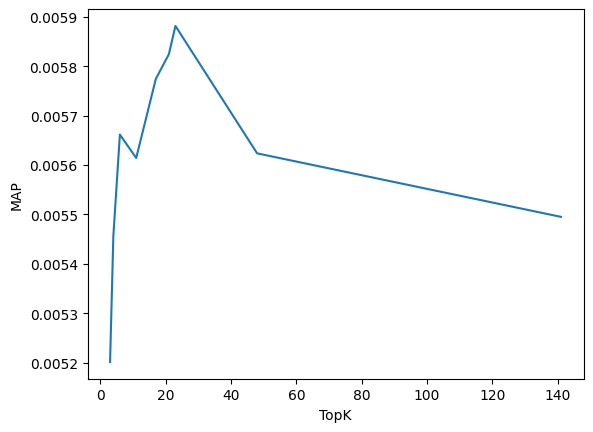

In [20]:
pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [21]:
hyperparameter_search_rnd

,k,MAP
2,3,0.005201
8,3,0.005201
1,4,0.005456
9,4,0.005456
4,6,0.005661
6,11,0.005614
10,17,0.005774
5,21,0.005824
3,23,0.005881
0,48,0.005623


In [22]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_k_value

hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = loguniform.rvs(0.1, 50, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]

for index in hyperparameter_search_rnd.index:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], 
                    topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 124 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2572.02 column/sec. Elapsed time 8.64 sec
EvaluatorHoldout: Processed 10000 (100.0%) in 6.53 sec. Users per second: 1531
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 124 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2376.19 column/sec. Elapsed time 9.35 sec
EvaluatorHoldout: Processed 10000 (100.0%) in 6.73 sec. Users per second: 1486
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 124 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2404.91 column/sec. 

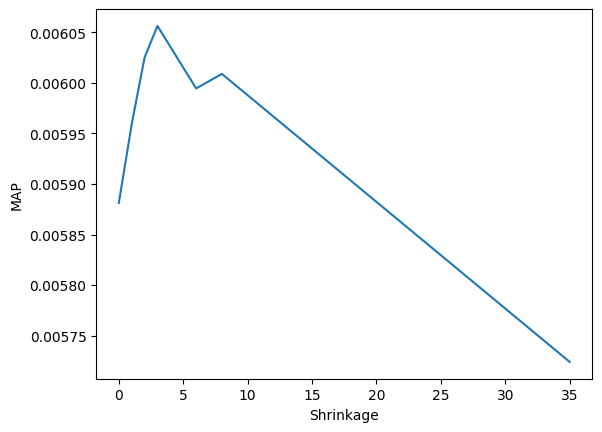

In [23]:
pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [24]:
best_parameters_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_parameters_value

k               23
shrink           3
MAP       0.006056
Name: 4, dtype: object

In [25]:
import time
recommender = ItemKNNCFRecommender(urm_sparse)
recommender.fit(shrink=best_parameters_value["shrink"], topK=best_parameters_value["k"])
n_users_to_test = len(data_target["user_id"])
suggestions = pd.DataFrame(columns = ["user_id", "item_list", "item_scores"])
start_time = time.time()

for user_id in (data_target["user_id"]-1):
    suggestion, suggestion_values = recommender.recommend(user_id, cutoff=10, return_scores=True)
    suggestions.loc[len(suggestions)] = [user_id+1, " ".join([str(item_map[x]) for x in suggestion]), " ".join([str(x) for x in np.flip(np.sort(suggestion_values))[0][:10]])]
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 1877.27 column/sec. Elapsed time 11.84 sec
Reasonable implementation speed is 619.29 usr/sec


In [26]:
#suggestions.to_csv('outputs/collaborative_item_item.csv', index=False)

In [27]:
suggestions

,user_id,item_list,item_scores
0,1,101 403 515 506 36 977 1546 869 922 318,1.9704008 1.750514 1.5578038 1.5354275 1.49453...
1,2,1095 11 47 28 50 4 12 5 136 6,1.4058849 1.3188555 1.3066249 1.2116627 1.1660...
2,3,59 956 584 2748 857 1281 536 259 2172 648,0.3344119 0.3292961 0.31564894 0.3086834 0.306...
3,4,28 50 249 136 145 5 277 111 363 122,2.1428757 1.9647391 1.6645603 1.5421509 1.5406...
4,5,1570 5138 77 7033 9039 4 238 116 148 20,1.1080153 1.0350269 0.9306607 0.92600083 0.922...
...,...,...,...
10877,13020,6450 6198 6452 7395 6749 7394 4323 12468 8743 ...,6.52352 6.0895486 6.045894 5.6441913 5.591287 ...
10878,13021,6179 6426 7027 6720 6451 6749 13621 20518 2050...,11.405987 10.792806 10.601754 10.198996 10.070...
10879,13022,1668 1446 1411 1674 809 10789 1561 8550 8100 1...,1.6723673 1.6144214 1.6026337 1.5664377 1.3270...
10880,13023,837 1107 1124 706 639 1534 978 1146 1290 828,1.4537846 1.3834087 1.3473324 1.3461387 1.3224...
